In [10]:
import sklearn
import numpy as np
from matplotlib import pyplot as plt
import pandas as pan
plt.style.use('dark_background')

## Importing training data

In [172]:
training_data = pan.read_csv('train_data.tsv',sep='\t')
print(training_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6333 entries, 0 to 6332
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   6333 non-null   int64 
 1   text_a  6333 non-null   object
dtypes: int64(1), object(1)
memory usage: 99.1+ KB
None


## Cleaning the data

In [3]:
import re
class cleaner:
   def __init__(self):
      self.links = re.compile(r'http\S+')
      self.amp = re.compile(r'[^,]*&amp[^,]*')
   def clean_data(self, data):
      data = self.links.sub('', data)
      s = data.encode('ascii',errors='ignore')
      data = s.decode()
      data = self.amp.sub('', data)
      return data

In [173]:
mr_clean = cleaner()
training_data['text_a'] = training_data['text_a'].apply(mr_clean.clean_data)
del mr_clean

### Quick analysis

In [5]:
import collections
import string
import nltk
nltk.download('stopwords')
class counter:
    def __init__(self):
        self.word_count = collections.Counter()
        self.stop_words = nltk.corpus.stopwords.words('english')
    def count(self, data):
        words = data.split(' ')
        for word in words:
            self.word_count[word] += 1
        self.word_count[''] = 0
        for word in self.stop_words:
            self.word_count[word] = 0
    def get(self, n):
        return self.word_count.most_common(n)
    def get_all(self):
        return self.word_count.most_common()

[nltk_data] Downloading package stopwords to /home/enei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Word occurrance in fake news

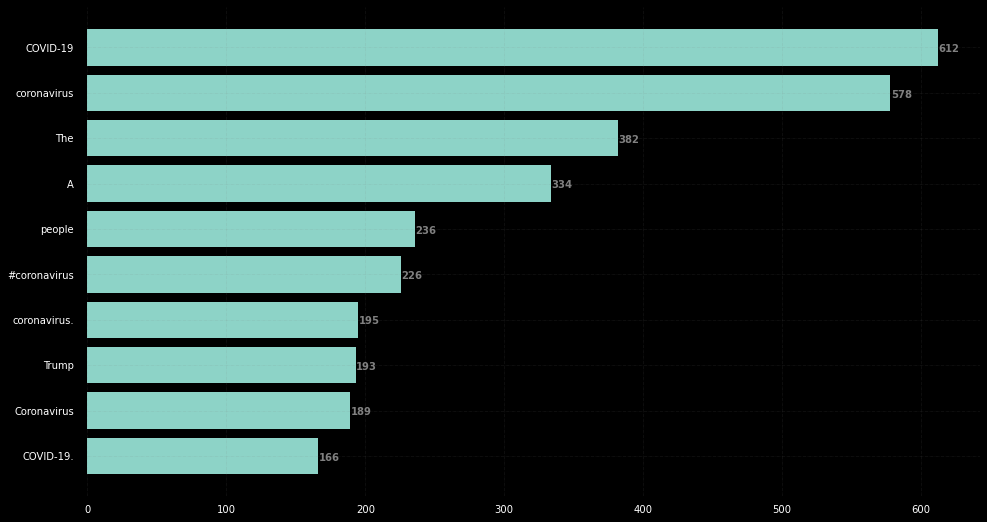

In [21]:
fig, ax = plt.subplots(figsize =(16, 9))
mr_count = counter()
training_data.loc[training_data['label'] == 0]['text_a'].apply(mr_count.count)
words = mr_count.get(10)
word, number = zip(*words)
plt.barh(word, number)
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
 
# Show Plot
plt.show()

#### Word occurrance in true news

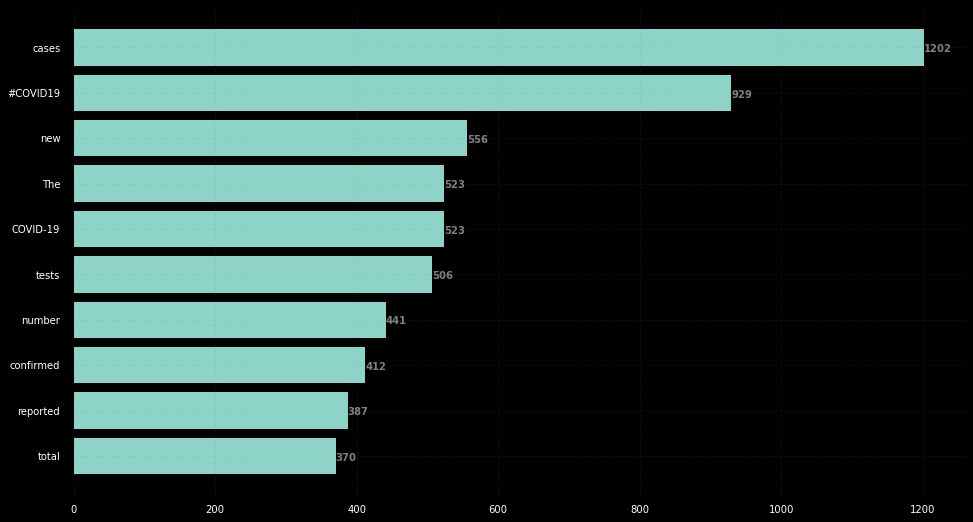

In [23]:
fig, ax = plt.subplots(figsize =(16, 9))
mr_count = counter()
training_data.loc[training_data['label'] == 1]['text_a'].apply(mr_count.count)
words = mr_count.get(10)
word, number = zip(*words)
plt.barh(word, number)
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
 
# Show Plot
plt.show()

## Feature construction

### Bag of words

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(training_data['text_a'])
vectorized_data = vectorizer.transform(training_data['text_a'])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### Tf-Idf encoding

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_data = tfidf_vectorizer.fit_transform(training_data['text_a'])

### Char vectorizer

In [79]:
from sklearn.feature_extraction.text import CountVectorizer
char_vectorizer = CountVectorizer(analyzer='char')
char_data = char_vectorizer.fit_transform(training_data['text_a'])

### Char ngrams 

In [80]:
from sklearn.feature_extraction.text import CountVectorizer
charwb_vectorizer = CountVectorizer(analyzer='char_wb')
charwb_data = charwb_vectorizer.fit_transform(training_data['text_a'])

## Modeling and evaluation

In [174]:
testing_data = pan.read_csv('test_data.tsv',sep='\t')
print(testing_data.info())
mr_clean = cleaner()
testing_data['text_a'] = testing_data['text_a'].apply(mr_clean.clean_data)
del mr_clean

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   2140 non-null   int64 
 1   text_a  2140 non-null   object
dtypes: int64(1), object(1)
memory usage: 33.6+ KB
None


In [185]:
# Model must be trained on the same feature constructor as used in combine
def combine(model1, model2, model3, feature_constructor):
    vectorized = feature_constructor.transform(testing_data['text_a'])
    out1 = model1.predict(vectorized)
    out2 = model2.predict(vectorized)
    out3 = model3.predict(vectorized)
    out = np.where((out1 + out2 + out3) < 2, 0, 1)
    length = len(out)
    out = np.where((testing_data['label'].to_numpy())==out, 1, 0)
    return np.sum(out)/length

### Logistic regression with bag of words

In [49]:
from sklearn.linear_model import LogisticRegression
lr_vec = LogisticRegression(solver='liblinear')
lr_vec.fit(vectorized_data, training_data['label'])

LogisticRegression(solver='liblinear')

In [160]:
vectorized = vectorizer.transform(testing_data['text_a'])
print(lr_vec.score(vectorized, testing_data['label']))

0.922429906542056


### Logistic regression with tfidf

In [42]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='liblinear')
lr.fit(tfidf_data, training_data['label'])

LogisticRegression(solver='liblinear')

In [123]:
vectorized = tfidf_vectorizer.transform(testing_data['text_a'])
print(lr.score(vectorized, testing_data['label']))

0.9177570093457944


### Logistic regression with char tokenizer

In [67]:
from sklearn.linear_model import LogisticRegression
lr_char = LogisticRegression(solver='liblinear')
lr_char.fit(char_data, training_data['label'])

LogisticRegression(solver='liblinear')

In [70]:
vectorized = char_vectorizer.transform(testing_data['text_a'])
print(lr_char.score(vectorized, testing_data['label']))

0.7897196261682243


### Logistic regression with char ngrams

In [81]:
from sklearn.linear_model import LogisticRegression
lr_charwb = LogisticRegression(solver='liblinear')
lr_charwb.fit(charwb_data, training_data['label'])

LogisticRegression(solver='liblinear')

In [82]:
vectorized = charwb_vectorizer.transform(testing_data['text_a'])
print(lr_charwb.score(vectorized, testing_data['label']))

0.7855140186915888


### K nearest neighbours with BOW

In [165]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(vectorized_data, training_data['label'])

KNeighborsClassifier(n_neighbors=2)

In [166]:
vectorized = vectorizer.transform(testing_data['text_a'])
print(knn.score(vectorized, testing_data['label']))

0.6504672897196262


### K nearest neighbours with TFIDF

In [143]:
from sklearn.neighbors import KNeighborsClassifier
knn_tfidf = KNeighborsClassifier(n_neighbors=2)
knn_tfidf.fit(tfidf_data, training_data['label'])

KNeighborsClassifier(n_neighbors=2)

In [144]:
vectorized = tfidf_vectorizer.transform(testing_data['text_a'])
print(knn_tfidf.score(vectorized, testing_data['label']))

0.6154205607476636


### Linear support vector with bow

In [156]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC(max_iter=10000)
lsvc.fit(vectorized_data, training_data['label'])

LinearSVC(max_iter=10000)

In [157]:
vectorized = vectorizer.transform(testing_data['text_a'])
print(lsvc.score(vectorized, testing_data['label']))

0.9130841121495327


### LSVC + LR + KNN with BOW

In [192]:
print(combine(neur, lr_vec, ab, vectorizer))

0.9341121495327103


### AdaBoost with bag of words

In [59]:
from sklearn.ensemble import AdaBoostClassifier
ab = AdaBoostClassifier(n_estimators=500)
ab.fit(vectorized_data, training_data['label'])

AdaBoostClassifier(n_estimators=500)

In [60]:
vectorized = vectorizer.transform(testing_data['text_a'])
print(ab.score(vectorized, testing_data['label']))

0.9144859813084112


### AdaBoost with tfidf

In [76]:
from sklearn.ensemble import AdaBoostClassifier
ab_tfidf = AdaBoostClassifier(n_estimators=200)
ab_tfidf.fit(tfidf_data, training_data['label'])

AdaBoostClassifier(n_estimators=200)

In [77]:
vectorized = tfidf_vectorizer.transform(testing_data['text_a'])
print(ab_tfidf.score(vectorized, testing_data['label']))

0.902803738317757


### AdaBoost with char tokenizer

In [71]:
from sklearn.ensemble import AdaBoostClassifier
ab_char = AdaBoostClassifier(n_estimators=200)
ab_char.fit(char_data, training_data['label'])

AdaBoostClassifier(n_estimators=200)

In [72]:
vectorized = char_vectorizer.transform(testing_data['text_a'])
print(ab_char.score(vectorized, testing_data['label']))

0.8598130841121495


### Neural network with bag of words

In [190]:
from sklearn.neural_network import MLPClassifier
neur = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=5000,
                     hidden_layer_sizes=(100, 500, 100, 20), random_state=0)
neur.fit(vectorized_data, training_data['label'])

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(100, 500, 100, 20),
              max_iter=5000, random_state=0, solver='lbfgs')

In [191]:
vectorized = vectorizer.transform(testing_data['text_a'])
print(neur.score(vectorized, testing_data['label']))

0.9313084112149532


### Neural network with tfidf

In [188]:
from sklearn.neural_network import MLPClassifier
neur_tfidf = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=5000,
                     hidden_layer_sizes=(50, 200, 50), random_state=0)
neur_tfidf.fit(tfidf_data, training_data['label'])

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(50, 200, 50), max_iter=5000,
              random_state=0, solver='lbfgs')

In [189]:
vectorized = tfidf_vectorizer.transform(testing_data['text_a'])
print(neur_tfidf.score(vectorized, testing_data['label']))

0.930841121495327


### Neural network with char wb

In [115]:
from sklearn.neural_network import MLPClassifier
neur = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=5000,
                     hidden_layer_sizes=(15, 7), random_state=0)
neur.fit(charwb_data, training_data['label'])

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(15, 7), max_iter=5000,
              random_state=0, solver='lbfgs')

In [116]:
vectorized = charwb_vectorizer.transform(testing_data['text_a'])
print(neur.score(vectorized, testing_data['label']))

0.8383177570093457


## Evaluation